In [13]:
#Leeds Butterfly Classification using a CNN(Convolutional Neural Network) 

#In this dataset we have 10 speciaes of butterfiles with a total of 800 pictures. 
#Through the use of a CNN we will be able to classify the dataset with an accuracy of over 90%. 
#One of the methods used to increase the accuracy of the model is by augmenting our data with ImageDataGenerator from kreas,
#to vastly increase the amout of data that we will be working with  
#Then the neural network will be trained by not looking at the same image twice, this will help in reducing overfitting.

import tensorflow as tf
import numpy as np
import pandas as pd
import os
import imageio
import shutil
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from IPython.display import Image
from shutil import copy

In [18]:
# These are the directories in wnich the dataset is stored(dataDirectory), where the model(modelDirectory) is stored
# and where the training and testing batch are split(workingDirectory)
#First we retrieve the list of filenames of the images and segments. 
#The first 3 characters of the filename represent the label. 
#We find the filenames and generate the labels from them. 
#From the lables we have subtracted 1 so that the lables are 0 indexed. 
#This will ensure that both the classification and prediciton are consistent.
dataDirectory= r'leedsbutterfly'
workingDirectory= r'working'
modelDirectory= r'models'
imageDirectory= os.path.join(dataDirectory, "images")
segmentationDirectory= os.path.join(dataDirectory, "segmentations")

In [19]:
imageFiles= [ files for files in os.listdir ( imageDirectory ) if os.path.isfile ( os.path.join (imageDirectory, files) ) ]
segmentationFiles= [ files for files in os.listdir ( segmentationDirectory ) if os.path.isfile ( os.path.join ( segmentationDirectory, files ) ) ]
label= np.array ( [files[:3] for files in imageFiles] ).astype ('int32') - 1

imageFiles= [ os.path.join( imageDirectory, files) for files in imageFiles]
segmentationFiles= [ os.path.join( segmentationDirectory, files) for files in segmentationFiles]

try: 
    os.mkdir( modelDirectory) 
except OSError as error:
    print("")

In [20]:
#Copy images and segmentations into the correct folder hierarchy in order
#for tensorflow.keras.preprocessing.image.ImageDataGenerator to correctly read and label the image files.
#We should end up with the following file structure

def copyFiles( filesNames, destinationDir, labelName):
    labelDestDir= os.path.join( destinationDir, str(lab))

    if os.path.isdir( labelDestDir):
        shutil.rmtree( labelDestDir, ignore_errors=True)
    os.makedirs( labelDestDir)
    [ copy( file , labelDestDir) for file in filesNames ]
    return

In [21]:
def copyImagesMasks( sample, mask, sampleDir, maskDir, label, currentLabel):
    sampleIdx= np.where( label == lab)[ 0]
    sampleData= np.array( sample)[ sampleIdx]
    masksData= np.array( mask)[ sampleIdx]

    copyFiles( sampleData, sampleDir, lab)
    copyFiles( masksData, maskDir, lab)

In [22]:
imageSegmentFiles= list( zip( imageFiles, segmentationFiles))
xTrainSeg, xTestSeg, yTrain, yTest= train_test_split( imageSegmentFiles, label, train_size=0.8, random_state=5634)
xTrain, xTrainSegment= zip( *xTrainSeg)
xTest, xTestSegment= zip( *xTestSeg)

uniqueLabels= np.unique( label)
trainDestDir= os.path.join( workingDirectory, "training")
trainSegmentDestDir= os.path.join( workingDirectory, "trainingSegment")
testDestDir= os.path.join( workingDirectory, "testing")
testSegmentDestDir= os.path.join( workingDirectory, "testSegment")

for lab in uniqueLabels:
    copyImagesMasks ( xTrain, xTrainSegment, trainDestDir, trainSegmentDestDir, yTrain, lab)
    copyImagesMasks ( xTest, xTestSegment, testDestDir, testSegmentDestDir, yTest, lab)


In [23]:
def showImagesFromFile(baseDir, lab, numImages= 25, numPerRow= 5):
    imageDirectory= os.path.join(baseDir, str(lab))

    filesImg= [ os.path.join( imageDirectory, files) for files in os.listdir( imageDirectory) if os.path.isfile( os.path.join( imageDirectory, files))]
    filesImg= filesImg[ :numImages]
    
    imagesPerRow= min( numImages, numPerRow)
    numRows= ( numImages - 1) // imagesPerRow + 1

    rowImages= []
    
    for row in range(numRows):
        currentFiles= filesImg[ row* imagesPerRow : (row+ 1)* imagesPerRow]
        imgs= [ tf.image.resize(imageio.imread(file), [96, 96], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR) for file in currentFiles]
        rowImages.append( np.concatenate(imgs, axis= 1))

    img= np.concatenate( rowImages, axis= 0)

    plt.figure( figsize= (imagesPerRow* 2, numRows* 2))
    plt.imshow( img, interpolation= 'nearest')
    plt.axis( "off")

    return

In [24]:
#We use the tensorflow.keras.preprocessing.image.ImageDataGenerator to create new images from the existing ones.
#The RGB values are rescaled from 0-255 to 0-1, for better acuraccy.We aslo zoom in on images and
#perform a slight shear to improve the training performance and
#to create more training data.We also ensure that the image and segmentation mask generators use the same seeds,
#so that they batch together the right images and segmetantion masks.

def createDataGenerator( dataDirectory, batch_size, dataSeed, target_size, arguments):
    datagen = ImageDataGenerator( **arguments)
    
    dataGenerator = datagen.flow_from_directory( dataDirectory,target_size=target_size,batch_size=batch_size,class_mode='categorical',seed=dataSeed)
    
    return dataGenerator

In [25]:
def createSampleMaskGenerator( sampleDir, maskDir, batch_size, dataSeed, target_size, arguments):
    sampleDataGen = createDataGenerator(sampleDir, batch_size, dataSeed, target_size, arguments)
    maskDataGen = createDataGenerator(maskDir, batch_size, dataSeed, target_size, arguments)
    
    return [sampleDataGen, maskDataGen]

In [26]:
batch_size= 34
dataSeed= 434
target_size= (92,92)

trainDataGenArgs= dict( 
    rescale= 1./255, rotation_range= 20, zoom_range= 0.15,
    width_shift_range= 0.15, height_shift_range= 0.15, horizontal_flip= True)

testDataGenArgs= dict( rescale=1./255 )

trainGenerator, trainMaskGenerator= createSampleMaskGenerator(
    trainDestDir, trainSegmentDestDir,batch_size,
    dataSeed, target_size, trainDataGenArgs
)

testGenerator, testMaskGenerator= createSampleMaskGenerator(
    testDestDir, testSegmentDestDir, batch_size,
    dataSeed, target_size, testDataGenArgs)

Found 665 images belonging to 10 classes.
Found 665 images belonging to 10 classes.
Found 167 images belonging to 10 classes.
Found 167 images belonging to 10 classes.


In [27]:
#First we create a CNN with a network of 3 Convolutional layers and 2 layers of fully connected neurons.
#We set the dropout rate to 50% for reguralization and because this problem is a multi classification one,
#we use categorical_crossentropy for the loss, and adam as the optimiser.

imgShape= target_size + (3,)

model= models.Sequential([
    layers.Conv2D( filters=32, kernel_size=(3, 3), activation='relu', input_shape=imgShape, name='conv_1'),
    layers.MaxPooling2D( pool_size=(2, 2)),
    layers.Conv2D( filters=32, kernel_size=(3, 3), activation='relu', name='conv_2'),
    layers.MaxPooling2D( pool_size=(2, 2)),
    layers.Conv2D( filters=64, kernel_size=(3, 3), activation='relu', name='conv_3'),
    layers.MaxPooling2D( pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense( 64, activation='relu', name= 'dense_1'),
    layers.Dropout(0.5),
    layers.Dense( 10, activation='sigmoid', name= 'outputs')
])

model.compile(
    loss= 'categorical_crossentropy', optimizer= 'adam', metrics= ['accuracy']
)

In [28]:
# There were issues when trying to train both the segments and the images, so first we wil train only the images

model.fit_generator(
    trainGenerator,
    steps_per_epoch= len( xTrain) // batch_size,
    epochs= 50,
    validation_data= testGenerator,
    validation_steps= len( xTest) // batch_size
)

Epoch 1/50
19/19 [==============================] - 28s 1s/step - loss: 2.3042 - accuracy: 0.1173 - val_loss: 2.2162 - val_accuracy: 0.2279
Epoch 2/50
19/19 [==============================] - 21s 1s/step - loss: 2.1778 - accuracy: 0.2456 - val_loss: 1.9995 - val_accuracy: 0.2941
Epoch 3/50
19/19 [==============================] - 20s 1s/step - loss: 2.0378 - accuracy: 0.2678 - val_loss: 1.7407 - val_accuracy: 0.4265
Epoch 4/50
19/19 [==============================] - 21s 1s/step - loss: 1.8459 - accuracy: 0.3233 - val_loss: 1.5061 - val_accuracy: 0.4485
Epoch 5/50
19/19 [==============================] - 20s 1s/step - loss: 1.7050 - accuracy: 0.3835 - val_loss: 1.2630 - val_accuracy: 0.5441
Epoch 6/50
19/19 [==============================] - 20s 1s/step - loss: 1.6824 - accuracy: 0.3867 - val_loss: 1.3539 - val_accuracy: 0.5000
Epoch 7/50
19/19 [==============================] - 21s 1s/step - loss: 1.5364 - accuracy: 0.4501 - val_loss: 1.2093 - val_accuracy: 0.5294
Epoch 8/50
19/19 [==

In [30]:
timeStamp= time.strftime( "%Y%m%d-%H%M%S")
modelFilename = os.path.join( modelDirectory, "modelNoMask{}.h5".format( timeStamp))

print( "Saving the model in the file {}".format( modelFilename))
model.save( modelFilename)

Saving the model in the file models\modelNoMask20220528-190202.h5


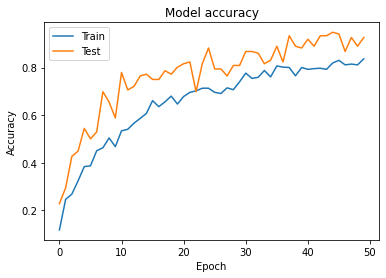

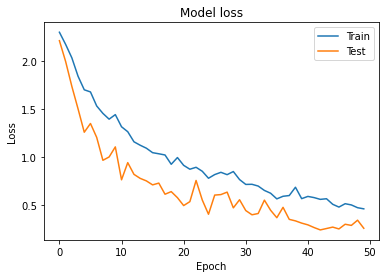

In [31]:
#Now we take a look at the accuracy and the loss history of the model to see how the performance improved.
#The model can achieve an accuracy of over 80%, but the issue is that it starts to overfit.
#Regularization is needed to run more epochs and to imporve accuracy.

history= model.history
plt.plot ( history.history [ 'accuracy' ] )
plt.plot ( history.history [ 'val_accuracy' ] )
plt.title ('Model accuracy')
plt.ylabel ('Accuracy')
plt.xlabel ('Epoch')
plt.legend ( ['Train', 'Test'], loc='upper left')
plt.show()

plt.plot ( history.history [ 'loss' ] )
plt.plot ( history.history [ 'val_loss' ] )
plt.title( 'Model loss' )
plt.ylabel( 'Loss' )
plt.xlabel( 'Epoch' )
plt.legend( [ 'Train' , 'Test' ], loc= 'upper right' )
plt.show()

In [32]:
#This time we will use a more sophisticated model that will reach an accuracy of 98%. 
#Since this model can take a few hours to run, we will be using early stopping and only the most accurate model will be saved.


timeStamp= time.strftime( "%Y%m%d-%H%M%S")
modelFilename= os.path.join( modelDirectory, "modelNoMask{}.h5".format( timeStamp))

earlyStop= EarlyStopping( monitor= 'loss', mode= 'min', patience= 50)
modelCheckpoint= ModelCheckpoint( modelFilename, monitor= 'val_accuracy', mode= 'max', save_best_only= True)

model_enhanced= models.Sequential([
    layers.Conv2D( filters= 32, kernel_size= (3, 3), kernel_initializer= 'he_normal', bias_initializer= 'random_uniform', activation= 'relu', input_shape= imgShape, name= 'conv_1'),
    layers.Conv2D( filters= 32, kernel_size= (3, 3), kernel_initializer= 'he_normal', bias_initializer= 'random_uniform', activation= 'relu', name= 'conv_2'),
    layers.MaxPooling2D( pool_size=(2, 2), strides=2),
    layers.Dropout( 0.2),
    layers.Conv2D( filters= 64, kernel_size= (3, 3), kernel_initializer= 'he_normal', bias_initializer= 'random_uniform', activation= 'relu', name= 'conv_3'),
    layers.Conv2D( filters= 64, kernel_size= (3, 3), kernel_initializer= 'he_normal', bias_initializer= 'random_uniform', activation= 'relu', name= 'conv_4'),
    layers.MaxPooling2D( pool_size= (2, 2), strides= 2),
    layers.Dropout( 0.2),
    layers.Conv2D( filters= 128, kernel_size= (3, 3), kernel_initializer= 'he_normal', bias_initializer= 'random_uniform', activation= 'relu', name= 'conv_5'),
    layers.Conv2D( filters= 128, kernel_size= (3, 3), kernel_initializer= 'he_normal', bias_initializer= 'random_uniform', activation= 'relu', name= 'conv_6'),
    layers.MaxPooling2D( pool_size= (2, 2), strides= 2),
    layers.Dropout( 0.3),
    layers.Flatten(),
    layers.Dense( 64, kernel_initializer= 'he_normal', activation= 'relu', name= 'dense_1', use_bias= False),
    layers.BatchNormalization(),
    layers.Dropout( 0.3),
    layers.Dense( 10, bias_initializer= 'random_uniform', activation= 'sigmoid', name= 'outputs')
])

model_enhanced.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

print(model.summary())

model_enhanced.fit_generator(
    trainGenerator,
    steps_per_epoch=len(xTrain) // batch_size,
    epochs=300,
    validation_data=testGenerator,
    validation_steps=len(xTest) // batch_size,
    callbacks=[
        earlyStop,
        modelCheckpoint
    ]
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 90, 90, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 43, 43, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 21, 21, 32)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 19, 19, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 9, 9, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5184)             

Epoch 47/300
19/19 [==============================] - 38s 2s/step - loss: 0.1091 - accuracy: 0.9799 - val_loss: 0.1179 - val_accuracy: 0.9559
Epoch 48/300
19/19 [==============================] - 35s 2s/step - loss: 0.1047 - accuracy: 0.9810 - val_loss: 0.1111 - val_accuracy: 0.9632
Epoch 49/300
19/19 [==============================] - 39s 2s/step - loss: 0.0944 - accuracy: 0.9810 - val_loss: 0.0991 - val_accuracy: 0.9779
Epoch 50/300
19/19 [==============================] - 36s 2s/step - loss: 0.1117 - accuracy: 0.9778 - val_loss: 0.1227 - val_accuracy: 0.9559
Epoch 51/300
19/19 [==============================] - 39s 2s/step - loss: 0.1116 - accuracy: 0.9746 - val_loss: 0.1742 - val_accuracy: 0.9338
Epoch 52/300
19/19 [==============================] - 38s 2s/step - loss: 0.0915 - accuracy: 0.9794 - val_loss: 0.0962 - val_accuracy: 0.9559
Epoch 53/300
19/19 [==============================] - 37s 2s/step - loss: 0.1070 - accuracy: 0.9731 - val_loss: 0.0920 - val_accuracy: 0.9853
Epoch 

19/19 [==============================] - 27s 1s/step - loss: 0.0414 - accuracy: 0.9826 - val_loss: 0.1311 - val_accuracy: 0.9632
Epoch 162/300
19/19 [==============================] - 31s 2s/step - loss: 0.0287 - accuracy: 0.9921 - val_loss: 0.0805 - val_accuracy: 0.9779
Epoch 163/300
19/19 [==============================] - 29s 2s/step - loss: 0.0271 - accuracy: 0.9921 - val_loss: 0.0592 - val_accuracy: 0.9779
Epoch 164/300
19/19 [==============================] - 27s 1s/step - loss: 0.0163 - accuracy: 0.9937 - val_loss: 0.0829 - val_accuracy: 0.9779
Epoch 165/300
19/19 [==============================] - 27s 1s/step - loss: 0.0317 - accuracy: 0.9873 - val_loss: 0.0381 - val_accuracy: 0.9853
Epoch 166/300
19/19 [==============================] - 29s 2s/step - loss: 0.0357 - accuracy: 0.9873 - val_loss: 0.2410 - val_accuracy: 0.9632
Epoch 167/300
19/19 [==============================] - 31s 2s/step - loss: 0.0649 - accuracy: 0.9826 - val_loss: 0.0155 - val_accuracy: 0.9926
Epoch 168/300

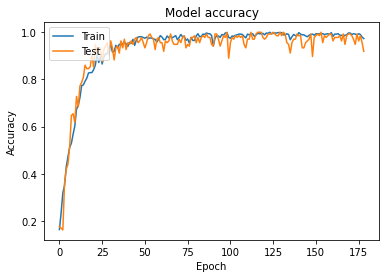

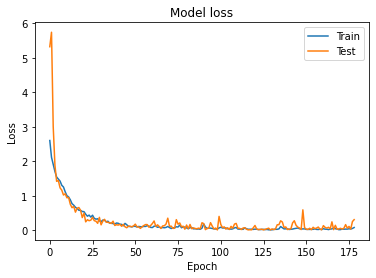

In [33]:
history= model_enhanced.history
plt.plot ( history.history [ 'accuracy' ] )
plt.plot ( history.history [ 'val_accuracy' ] )
plt.title ( 'Model accuracy' )
plt.ylabel ( 'Accuracy' )
plt.xlabel ( 'Epoch' )
plt.legend ( [ 'Train', 'Test' ], loc='upper left' )
plt.show()

plt.plot ( history.history [ 'loss' ] )
plt.plot ( history.history [ 'val_loss' ] )
plt.title ( 'Model loss' )
plt.ylabel ( 'Loss' )
plt.xlabel ( 'Epoch' )
plt.legend ( [ 'Train', 'Test' ], loc='upper right' )
plt.show()

In [34]:
#Because the predictions are slow, we will store them in a variable.

def generatePrediction(fileDirectory, model):
    prediction= []

    for lab in os.listdir(fileDirectory):
        imgs= []
        filesImg= os.listdir(os.path.join(fileDirectory, lab))
        
        print( "Generating predictions for label: {} with {} files".format( lab, len(filesImg)))

        for file in filesImg:
            rawImage= imageio.imread( os.path.join( fileDirectory, lab, file))
            resizeImage= tf.image.resize( rawImage, target_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
            resizeImage= resizeImage / 255

            imgs.append( resizeImage)

        classPredictions= model.predict_classes(np.array(imgs), batch_size=len(imgs))
        
        prediction.append ([lab, classPredictions])
        
    return prediction

In [35]:
savedModel = tf.keras.models.load_model(modelFilename)

In [36]:
prediction = generatePrediction(testDestDir, savedModel)

Generating predictions for label: 0 with 16 files


C:\Users\Temp\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Generating predictions for label: 1 with 15 files
Generating predictions for label: 2 with 7 files
Generating predictions for label: 3 with 20 files
Generating predictions for label: 4 with 21 files
Generating predictions for label: 5 with 21 files
Generating predictions for label: 6 with 16 files
Generating predictions for label: 7 with 10 files
Generating predictions for label: 8 with 21 files
Generating predictions for label: 9 with 20 files


----------------------------------------------------------------------------
The class 0 has 0 misclassifications

----------------------------------------------------------------------------
The class 1 has 0 misclassifications

----------------------------------------------------------------------------
The class 2 has 0 misclassifications

----------------------------------------------------------------------------
The class 3 has 0 misclassifications

----------------------------------------------------------------------------
The class 4 has 1 misclassifications

Misclassified as 9


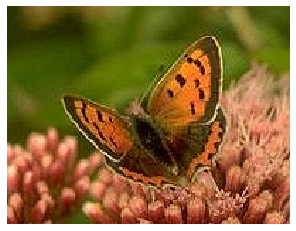

----------------------------------------------------------------------------
The class 5 has 0 misclassifications

----------------------------------------------------------------------------
The class 6 has 1 misclassifications

Misclassified as 5


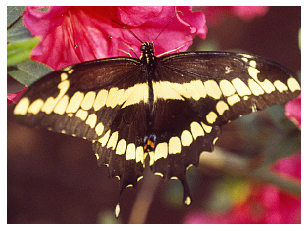

----------------------------------------------------------------------------
The class 7 has 0 misclassifications

----------------------------------------------------------------------------
The class 8 has 1 misclassifications

Misclassified as 6


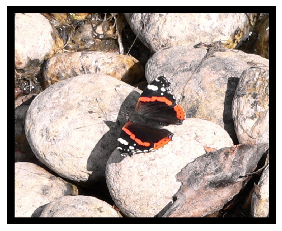

----------------------------------------------------------------------------
The class 9 has 0 misclassifications



In [37]:
#Here we can see the the classification report and see which images were incorrectly classified.
for lab, pred in prediction:
    misclassificationIdx= np.where (np.array (pred) != np.int (lab))[0]

    print("----------------------------------------------------------------------------")
    print("The class {} has {} misclassifications".format(lab, len(misclassificationIdx)))
    print("")

    filesImg= os.listdir(os.path.join(testDestDir, lab))
    
    for i in misclassificationIdx:
        print("Misclassified as {}".format(pred[i]))

        misclassFile= filesImg[i]
        img= imageio.imread(os.path.join(testDestDir, lab, misclassFile))
        plt.imshow(img, interpolation= 'nearest')
        plt.axis("off")
        plt.show()